In [1]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import concurrent.futures

## Group Assignment
### Team Number: 4
### Team Member Names: Jacky Xu, Esha Kumar, Jingyi Fang
### Team Strategy Chosen: SAFE

#### Filtering
Our first goal was to filter through the stocks provided. We started off by creating a function, call_tickers, that created a list with all the tickers. Next, we created a function called get_ticker_info to get information on the tickers’ market, average daily volume from 2021-07-02 to 2021-10-22, and the closing price on 2021-11-26. After that, we loop through the result to ignore any delisted tickers, tickers that are not dominated in the US market, and tickers that fail to meet the average daily volume requirement. We store the ticker name and the closing price on 2021-11-26 into a data frame called ticker_info.  

In [2]:
# call_tickers takes a list of tickers and return a list of called tickers
def call_tickers(lst):
    # create an empty list to store the called tickers
    called_tickers= []
    # iterate the ticker list
    for i in lst:
        # call each ticker and append it to the called ticker list
        called_tickers.append(yf.Ticker(i))
    # return the called ticker list when finish
    return called_tickers

In [25]:
# get_ticker_info takes a called ticker, returns a list of ticker name, currency, average daily volume and closing price on Nov 26
def get_ticker_info(i):
    # extract the ticker name
    ticker_name = str(i)[24:-1]
    # use try and except to ignore the delisted stocks
    try:
        # extract the market, average daily volume from 2021-07-02 to 2021-10-22 and closing price on 2021-11-26
        market =  i.info['market']
        avg_daily_volume = i.history(start = "2021-07-02", end = "2021-10-22" ,interval='1d')['Volume'].mean()
        price1126 = i.history(start = '2021-11-26', end = '2021-11-27',interval='1d')['Close'][0]
        # return a list with the information 
        return [ticker_name,market,avg_daily_volume,price1126]
    except:
        pass

#### Calculating Returns
We now had a list of tickers we could work with, we call the ticker again, then get the historical data of the tickers through a function called get_price. We also wanted a function that would give us the weekly returns, get_weekly_returns, since the competition would only last 6 days, as well as a function that would give us monthly returns, get_monthly_returns, for beta calculations later on.  

In [4]:
# get_prices takes a list of called tickers, start date and end date, returns the historical prices in the given time period
def get_prices(lst,start,end):
    # open an empty dataframe
    prices = pd.DataFrame()
    # iterate the ticker list
    for i in lst:
        # extract the historical closing prices and store into the dataframe
        prices[str(i)[24:-1]] = i.history(start = start,end=end,interval = '1d')['Close']
    # return the prices
    return prices

In [5]:
# get_weekly_returns takes the historical prices(or portfolio value) and returns the weekly returns
# usually we use monthly returns but since the competition only lasts for 6 days, we decided to use the weekly returns
def get_weekly_returns(prices):
    weekly_returns = prices.resample('W').first().pct_change()
    weekly_returns = weekly_returns.iloc[1:]
    return weekly_returns

In [6]:
# we still use monthly returns to calculate the beta
def get_monthly_returns(prices):
    monthly_returns = prices.resample('MS').first().pct_change()
    monthly_returns = monthly_returns.iloc[1:]
    return monthly_returns

#### Ranking std
Now we can start ranking our stocks. We decided to begin with ranking the stocks based on standard deviation. Our goal is to have the least fluctuating stocks to have a safe profile. We started off by simply calculating the standard deviations of the price of each stock and storing them in a data frame with a function called get_std. We used the used the built-in rank function to rank the std data frame.  

In [7]:
# get_std takes the prices of the stock and returns the std of the prices
def get_std(prices):
    # open an empty dataframe with column names set up
    std = pd.DataFrame(columns = ('ticker','std'))
    # set the index
    index = 0
    # iterate through the ticker names
    for i in prices.columns:
        # store the ticker name and the std of prices
        std.loc[index] = [i, prices[i].std()]
        # add 1 to the index
        index += 1
    # return the std
    return std

In [8]:
# rank takes a dataframe, column name and method and ranks the dataframe by the given column using the given method
def get_rank(df,column_name,method):
    # use the built-in rank function to rank the dataframe, store the rankings in a new column
    df[column_name+'_rank'] = df[column_name].rank(method=method)
    # return the ranked dataframe
    return df

#### Ranking beta
We also want to take beta into consideration when ranking our stocks. Beta is risk related to the overall market. Since it is a risk we cannot eliminate, we must work around it when choosing our stocks. We created a function called get_beta to calculate the beta of each stock. We will later rank the betas. For this profile, we will want the stocks with the lowest beta because a lower beta means lower risk in relation to the overall market.  

In [9]:
# Calculating Beta
def get_beta(good_tickers, prices, start_date, end_date, ticker_symbols):
    Ticker = '^GSPC'
    # The symbol yfinance uses for the S&P 500
    MarketIndex = yf.Ticker(Ticker) 
    MarketIndex_hist = MarketIndex.history(start=start_date, end=end_date)

    # DataFrame for Market Index
    marketDF = pd.DataFrame(MarketIndex_hist['Close'])
    marketDF.columns = [Ticker]
    

    # Loop iterates through the column of prices
    betaList = []
    for i in range(len(ticker_symbols)):
        currentStockPrice = prices[ticker_symbols[i]]
        currentStockPrice = pd.concat([currentStockPrice, marketDF], join = 'inner', axis=1)
        
        # Getting the Monthly Return of each stock
        monthly_returns = currentStockPrice.resample('MS').first().pct_change()  
        # Dropping the first entry (since it's N/A)
        monthly_returns.drop(index=monthly_returns.index[0], inplace=True)
        
        
        # Calculate the market variance (you will need to reference the column correponding to the market)
        MarketVar = monthly_returns[Ticker].var()
        
        betaList.append(monthly_returns.cov() / MarketVar)
        
    # Filter through betaList and extract the beta for each stock
    for i in range(len(betaList)):
        betaList[i] = betaList[i].iat[0,1]
    
    # Creating a DataFrame for Tickers and their Beta value
    beta = pd.DataFrame(columns = ('ticker','beta'))
    for i in range(len(good_tickers)):
        beta.loc[i] = [str(good_tickers[i])[24:-1], betaList[i]]

    return beta

#### Final Ranking
Then we ranked the stocks again with a function called get_std_beta_rank. We ranked the stocks again based on standard deviation and beta by combining the two data frames and adding their ranks. We multiplied the standard deviation ranking by 8 because we value standard deviation more than beta. Therefore, it will hold more value when we rank the stocks. Now we have our stocks ranked based on standard deviation and beta.  

In [10]:
# get_std_beta_rank takes the ranked std dataframe and the ranked beta dataframe, 
# rank the dataframe by both and return the top 30 stocks
def get_std_beta_rank(std,beta):
    # combine the std dataframe and the beta dataframe
    rank = pd.concat([std,beta['beta'],beta['beta_rank']],join='inner',axis=1)
    # add up the ranks to get the final rank
    rank['final_rank'] = rank['std_rank']*8 + rank['beta_rank']
    # rank by the final rank
    rank = rank.sort_values(by='final_rank')
    # takes the top 30 stocks
    rank = rank[:30]
    # return the dataframe
    return rank

#### Pair by Correlation
Another factor to consider when choosing our stocks was correlation. We wanted to pair stocks that have negative correlation with each other because low correlation reduces the risk of our portfolio by having stocks that move in opposite directions. So, we proceeded by creating a function, get_correlation, to calculate the correlation of each stock and rank the correlation based on weekly returns. Then, we created a function called pair_by_corr that produced ten pairs of stocks, each of which are least correlated to each other.  

In [11]:
# get_correlation takes a ticker(self), calculates and ranks the correlations between self and the rest of the tickers in the given dataframe(std_rank)
def get_correlation(self,std_rank,prices,length):
    # open an empty dataframe
    rank = pd.DataFrame()
    # get the weekly return of self
    self_weekly_returns = pd.DataFrame(get_weekly_returns(prices[self]))
    # iterate rest of the tickers
    for i in range(1,length):
        # get the ticker name and the weekly returns
        candidate = std_rank.index[i]
        candidate_weekly_returns = pd.DataFrame(get_weekly_returns(prices[candidate]))
        # calculate the correlations
        corr = self_weekly_returns[self].corr(candidate_weekly_returns[candidate])  
        # store the correlation
        rank[candidate] = [corr]
    # return the transposed dataframe
    return rank.T

In [12]:
# pair_by_corr takes the ranked dataframe and the prices of the stocks, 
# returns a dataframe that stores 10 pairs of stocks with the lowest correlation
def pair_by_corr(std_beta_rank, prices):
    # open an empty dataframe
    pairs = pd.DataFrame()
    # counter is the number of pairs
    counter = 0
    # loop until we have 10 pairs
    while counter < 10:
        # self is the stock that has lowest std and beta(which is the safest one)
        self = std_beta_rank.index[0]
        # get the weekly_returns for self
        self_weekly_returns = pd.DataFrame(get_weekly_returns(prices[self]))
        # get the dataframe that stores the ranked correlations between self and all other stocks in the std-ranked dataframe
        corrs = get_correlation(self,std_beta_rank,prices,len(std_beta_rank)-1)
        # rename the column for the correlation dataframe
        corrs.columns = ['corr']
        # sort the correlation dataframe in asending order
        corrs = corrs.sort_values(by='corr')
        # champion would be the ticker that is least correlated with self
        champion = corrs.index[0]
        #  get the weekly return for the champion 
        champion_weekly_returns = pd.DataFrame(get_weekly_returns(prices[champion]))
        # get the closing price on start date for both self and champion
        self_price = prices[self][0]
        champion_price = prices[champion][0]
        # calculate the number of shares we could purchase using the price
        self_shares = 100000 /  self_price
        champion_shares = 100000 /  champion_price
        # get weekly price, portfolio value, and portfolio return for self and champion
        pairs[self+'_price'] = prices[self].resample('W').first()
        pairs[self+'_value'] =  pairs[self+'_price']*self_shares
        pairs[self+'_return'] = pd.DataFrame(get_weekly_returns(pairs[self+'_value']))
        pairs[champion+'_price'] = prices[champion].resample('W').first()
        pairs[champion+'_value'] =  pairs[champion+'_price']*champion_shares
        pairs[champion+'_return'] = pd.DataFrame(get_weekly_returns(pairs[champion+'_value']))
        # remove self and champion from the ranked dataframe to prepare for the next iteration
        std_beta_rank = std_beta_rank[1:]
        std_beta_rank = std_beta_rank[std_beta_rank.index != str(champion)]
        # add 1 to the counter for each finished pair
        counter += 1
    # return the pairs
    return pairs


#### Calculating Difference
Our goal is to minimize the difference between the portfolio value and the 100,000 we have to spend, so we created a function to calculate the maximum difference between the portfolio value and 100,000. This way we can prepare for the worst case scenario. 

In [13]:
# get_difference calculates the max difference between the given portfolio value and $100000
def get_difference(df): 
    return max(abs(df['value'].max()-100000) , abs(df['value'].min()-100000))

#### Create Portfolio
Since, we have ten pairs of stocks that have the lowest possible correlations, we want to create ten portfolios, one for each pair. In the create_portfolio function, we iterate through all possible weightings in the range to find the weight that produces minimal difference between the individual portfolio values and 100,000.   

In [14]:
# create_portfolio takes two stocks and the pairs dataframe, returns the optimal weight, minimal difference, 
# and the weighted portfolio with the minimal difference
def create_portfolio(range_min,range_max,stock1,stock2,pairs):
    # open an empty portfolio 
    candidate = pd.DataFrame()
    champion = 0
    # min_difference stores the the sign of the lowest difference and the absolute value of the lowest difference
    min_difference = [1, 100000]
    # weight_1 is the weight of stock1
    weight_1 = 0
    # iterates the given range
    for i in range(range_min,range_max+1):
        # get the portfolio value of each pair by multiplying the weight and the value of each stock
        # add them up and double the result since each stock value starts from 50000
        candidate['value'] = pairs[stock1+'_value']*(i/100)+pairs[stock2+'_value']* (1-i/100)
        # calculate the max difference between the portfolio value and 100000
        difference = get_difference(candidate)
        # if the absolute value of the difference(since the difference could be negative) is less than the min_difference
        if abs(difference) <= min_difference[1]:
            # if the portfolio is roughly greater than 100000, we assume that the difference is positive
            if candidate['value'].median() > 100000:
                # replace the min_difference with current difference(with positive sign )
                 min_difference = [1 ,abs(difference)]
            # otherwise it's a negative sign
            else:
                min_difference = [-1 ,abs(difference)]
            # update the champion and the weight
            champion = candidate
            weight_1 = i
    # return the optimal weight, minimal difference
    return weight_1, min_difference


### Strategy Overview

Before starting this project, we began by developing a strategy. Our first step was to extract the stock data from the csv file. Next, we had to filter through the stocks. We were given two restrictions. The first was to only include stocks dominated in USD (US listed stocks). The second was to only include stocks in our portfolio that have an average daily volume of at least 10,000 shares, based on the time interval of July 02, 2021 to October 22, 2021. We created a function that could filter through the csv file to only include stocks in the US market and meet the average daily volume requirement. 

Next, we had to find a way to choose and rank our stocks so we could later assign each stock weights. We decided to use standard deviation and beta to rank our stocks. Standard deviation would tell us which stocks are the least risky. Beta is the risk related to the overall market, so we decided it was important to take beta into consideration when ranking our stocks.  

After choosing and pairing our stocks based on standard deviation and beta, we wanted to pair the stocks based on correlation. Since we want to reduce the risk of our portfolio, we ideally wanted the pairs to be negatively correlated. Of course, this is not possible, so we simply want the pairs to have the least possible correlation. So, we wanted a function that would choose 10 pairs of stocks. Stock 1 in each individual pair would be one of the top 10 ranked stocks, while stock 2 would be the stock that has the least correlation with stock 1. 

After we have the 10 pairs of stocks, we want to create a portfolio for each pair. Then, we can find the optimal weight that produces the minimal difference between the portfolio value and $100,000. This is our ultimate goal.  

The final part is to calculate the weight of each stock that would minimize the total differences. 
We first loop through the pairs to store their differences, then assign different weights for the pairs with positive differences and negative differences so that they counterbalance each other. Another requirement we we have is we need to ensure that each stock is in the range (100/2n %, 35%). After completing this, we can finally apply the weights of each pair to get the final weight for each stock and build the final portfolio accordingly.



#### Start coding
Now, we have all the functions, and we will start to run our code. 


In [15]:
# read the ticker file
tickers = pd.read_csv("Tickers.csv",header=None)
# rename the column as "ticker"
tickers.columns=['ticker']
# create a list that contains all the tickers
ticker_lst = tickers['ticker'].tolist()

# set up the start date and the end date
start_date = "2021-07-02"
end_date = "2021-11-26" 

# call the tickers
called_tickers = call_tickers(ticker_lst)


In [16]:
# open an empty dataframe and a list to store the ticker info and the tickers
ticker_info = pd.DataFrame()
tickers = []
# Using threading to run the get_ticker_info function, store the result
with concurrent.futures.ThreadPoolExecutor() as executor:
    result = executor.map(get_ticker_info, called_tickers)
# iterates the results to filter the tickers
for i in result:
    try:
        # filter the USD tickers
        if i[1] == 'us_market':
            # filter the average daily volume
            if i[2] > 10000:
                # store the eligible ticker and its closing price on 2021-11-26
                ticker_info[i[0]] = [i[3]]
    except:
        pass
# format the ticker_info dataframe
ticker_info = ticker_info.T
ticker_info.columns = ['11-26_price']
ticker_info.head()

- PCLN: None
- PCLN: None
- TWX: No data found for this date range, symbol may be delisted
- TWX: No data found for this date range, symbol may be delisted


,11-26_price
AAPL,161.940002
ABBV,118.660004
ABT,125.070000
ACN,362.369995
AIG,57.889999


In [17]:
# call the tickers again
good_tickers = call_tickers(ticker_info.index)

# extract the closing prices for the good tickers
prices = get_prices(good_tickers, start_date, end_date)

# Get a list of Ticker Symbols (list of Strings)
ticker_symbols = prices.columns

# calculate the std according to the closing prices
std = get_std(prices)

# rank them in ascending order
std = get_rank(std,'std','min')

# calculate the std according to the closing prices
std = get_std(prices)

# rank them in ascending order
std = get_rank(std,'std','min')

# calculate the beta according to the closing prices
beta = get_beta(good_tickers, prices, start_date, end_date, ticker_symbols)

# rank them in ascending order
beta = get_rank(beta,'beta','min')

# combine the rank of std and beta, rank the combined rank, then format the result dataframe
std_beta_rank = get_std_beta_rank(std,beta)
std_beta_rank.set_index('ticker',inplace=True)
std_beta_rank.head()

,std,std_rank,beta,beta_rank,final_rank
ticker,,,,,
MON,0.047961,1.0,-0.103421,12.0,20.0
KMI,0.686552,2.0,-0.414728,9.0,25.0
T,0.851036,3.0,-0.320710,10.0,34.0
MO,1.626807,5.0,0.518204,23.0,63.0
KO,1.159795,4.0,1.050870,34.0,66.0


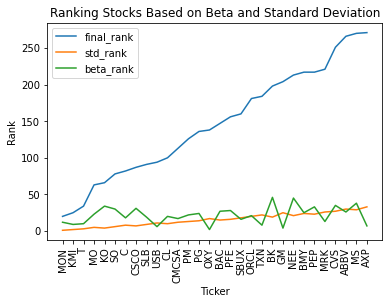

In [19]:
# Plot the data
plt.plot(std_beta_rank.index, std_beta_rank.final_rank, label = 'final_rank')
plt.plot(std_beta_rank.index, std_beta_rank.std_rank, label = 'std_rank')
plt.plot(std_beta_rank.index, std_beta_rank.beta_rank, label = 'beta_rank')

#Define label
plt.title('Ranking Stocks Based on Beta and Standard Deviation')
plt.xlabel('Ticker')
plt.ylabel('Rank')

# Create legend
plt.legend(loc='best')

# Rotate x-axes by 90 degrees
plt.xticks(rotation=90)

plt.show()

In the graph above, we can see that the standard deviation rankings have an upward moving trend, whereas beta rankings have no trend. The graph shows that stocks with a higher standard deviation ranking are ranked higher overall. This is because we know that stocks with a higher deviation are riskier. Although the beta rankings do not seem to affect the final ranking (because there is no trend), they must be considered because beta is the market-related risk, as discussed earlier.

In [18]:
# get the pair portfolios
pairs = pair_by_corr(std_beta_rank,prices)
pairs.head()

,MON_price,MON_value,MON_return,SO_price,SO_value,SO_return,KMI_price,KMI_value,KMI_return,NEE_price,...,USB_return,CL_price,CL_value,CL_return,CMCSA_price,CMCSA_value,CMCSA_return,ORCL_price,ORCL_value,ORCL_return
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-04,9.655,100000.000000,NaN,60.274460,100000.000000,NaN,18.005268,100000.000000,NaN,73.615639,...,NaN,80.773155,100000.000000,NaN,58.169998,100000.000000,NaN,81.236694,100000.000000,NaN
2021-07-11,9.730,100776.797632,0.007768,60.382214,100178.771828,0.001788,17.879223,99299.953623,-0.007000,74.458031,...,-0.027098,81.040092,100330.477688,0.003305,57.660000,99123.262270,-0.008767,82.487724,101539.981382,0.015400
2021-07-18,9.700,100466.080555,-0.003083,60.538948,100438.806455,0.002596,17.956789,99730.750578,0.004338,74.418388,...,0.028031,81.989204,101505.511566,0.011712,58.259998,100154.719194,0.010406,86.459198,106428.749600,0.048146
2021-07-25,9.670,100155.363477,-0.003093,61.508747,102047.778222,0.016019,16.657539,92514.808877,-0.072354,76.301399,...,-0.053317,83.017410,102778.466509,0.012541,56.630001,97352.592145,-0.027978,86.678474,106698.672484,0.002536
2021-08-01,9.675,100207.151303,0.000517,62.429565,103575.487191,0.014971,17.287771,96015.072544,0.037835,76.222122,...,0.030637,83.583977,103479.895673,0.006825,58.700001,100911.127060,0.036553,87.555428,107778.176189,0.010117


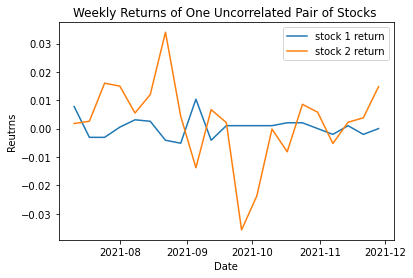

In [27]:
# plot the return of the first pair
plt.plot(pairs.index,pairs.iloc[:,2],label = 'stock 1 return')
plt.plot(pairs.index,pairs.iloc[:,5],label = 'stock 2 return')

# Define label
plt.title('Weekly Returns of One Uncorrelated Pair of Stocks ')
plt.xlabel('Date')
plt.ylabel('Reutrns')

# Create legend
plt.legend(loc='best')

plt.show()

Since we do not know the tickers that will be given to us, we cannot know the specific details of the graph. However, the graph should show that the paired stock is generally not correlated. As one stock’s returns increase, the other’s decrease, and vice versa. Thus, we know that we are reducing the risk of our portfolio, since the pairs are reducing each other.

#### Calculating Weight

#### For loop explained:

In order to produce the optimal portfolio value with a return on investment as close to 0 dollar as possible, we would have to allocate varying percentages of our investment into different stocks. Since we have paired the twenty stocks we would invest into by their correlation, we would have to determine how much of our investment would go into each stock so that each pair would balance out and return the lowest difference in price. This is done through the create_portfolio function. 
The purpose of the for loop outside of main function is to vary the range of the weightings by increasing the minimum weighting and the maximum weighting. In specific, the loop will start at a minimum weighting of 1\% and a maximum weighting of 99\% (a range of 98\%) and finish its iterations at a minimum weighting of 49\% and a maximum weighting of to 51\% (so a range of 2\%).  For each iteration, we compare the current portfolio value of the current minimum and maximum weighting against the lowest portfolio value so far. If the current portfolio value is closer to $100,000 by the last date, lowest will be replaced by the current portfolio with its current minimum and maximum weights.

#### Inside the for loop:

Given the range of weightings, we calculate the optimal weight for each stock within the range and using the weight to calculate the final portfolio value. The porfolio value that is closest to $100,000 would be stored. 

We first collect the information we need, which is the optimal weight and minimal difference of each pair, through the create_portfolio function. Then, we store this information into a data frame called weights, and separate the pairs according to the sign of their differences into two portfolios: pos_diff and neg_diff. Our goal is to weigh the positive differences and the negative differences to a 50-50 percentage to cancel each other, and at the same time ensure that these weights would also produce the final weight of each stock in the range of (100/2n %, 35 percent %). We started by calculating the maximum and minimum weight of each stock, which then allows us to calculate the optimal weight that counterbalances the positive and negative differences to the greatest extent. Once we have the weights for positive and negative differences, we apply that to each pair and get the final weight of each stock. Then we build the final portfolio using the final weight and check the difference between the final portfolio value and $100,000.  

In [20]:
# Initializing a DataFrame named lowest, where it has a column named “final” where each element is extremely large. 
# Doing so makes sure that lowest will be replaced inside the for loop 
bigNum = []
for i in range (len(pairs)):
    bigNum.append(1230918230)
lowest = pd.DataFrame({"final": bigNum})
for w in range(49):
    # we now write a for loop to iterates each of the 10 pairs to store  
    # 1). the optimal weight of the pair portfolio, 
    # 2). the ticker names
    # 3). the minimal difference between the portfolio value and $100000

    # open empty lists to store the information we need
    portfolio_weights = []
    diffs = []
    stock1_symbols = []
    stock2_symbols = []
    # extract all ticker names from the columns of the pairs dataframe
    symbols = pairs.filter(like='_price', axis=1).columns
    # get the number of pairs
    num_of_pairs = round(len(symbols)/2)

    # iterates the paris 
    for i in range(num_of_pairs):
        # get the ticker names for the pair of stocks, and append to the corresponding symbol lists
        stock1 = symbols[0][:-6]
        stock1_symbols.append(stock1)
        stock2 = symbols[1][:-6]
        stock2_symbols.append(stock2)

        # create a portfolio with the pair, then store the optimal stock weight and the minimal difference
        w1, diff = create_portfolio(1+w,99-w,stock1,stock2,pairs)
        portfolio_weights.append(w1)
        diffs.append(diff)
        # remove the finished pair
        symbols = symbols[2:]
        
    # decorate the differences with signs
    for i in range(num_of_pairs):
        diffs[i] = diffs[i][0]*diffs[i][1] 
    
    
    # create a dataframe with the weights and the differences
    weights = pd.DataFrame(portfolio_weights, diffs)
    # format the dataframe, calculate the stock 2 weight and add the ticker names in
    weights.reset_index(inplace=True)
    weights.columns = ['diff','stock1_weight']
    weights['stock1_symbol'] = stock1_symbols
    weights['stock2_weight'] = 100 - weights['stock1_weight']
    weights['stock2_symbol'] = stock2_symbols
    # separate the pairs with positive differences and negative differences
    pos = weights[weights['diff'] > 0]
    neg = weights[weights['diff'] < 0]
    # calculate the sum of positive differences and negative diffrences
    pos_diff = pos['diff'].sum()
    neg_diff = neg['diff'].sum()
    # calculate the total differences
    total_diff = pos_diff - neg_diff
    # calculate the current weights of positive and negative differences
    pos_weight = pos_diff/total_diff
    neg_weight = (neg_diff/total_diff)*-1
    # get number of stocks
    num_of_stocks = num_of_pairs*2
    # each stock must make up a minimum of (100/(2n))% of the portfolio , we add 0.01 just in case
    # since each stock is already weighted in its pair portfolio, we need to cancel that weight so we divide
    min_weight = ((100/(num_of_stocks*2))+0.01)/(1+w)
    max_weight = (35-0.01)/(99-w)

    # our goal is to weight the positive differences and the negative differences to a 50-50 percentage
    # so that they can cancel each other

    # when positive differences is less than the negative difference, 
    if pos_weight < neg_weight:
        # In order to get the maximized positive weight, we determine the minimal negative weight and subtract it from 1
        # we use minimal negative weight instead of maximum positive weight because it is very likely that we assign
        # too much weight on the positive side, and stocks in negative differences would end up failling the 100/2n % range
        neg_weight = min_weight*len(neg)
        pos_weight = 1 - neg_weight
    else:
        # same logic here
        pos_weight = min_weight*len(pos)
        neg_weight = 1 - pos_weight
    
    # apply the weights
    pos['stock2_weight']*= pos_weight/len(pos)
    pos['stock1_weight']*= pos_weight/len(pos)
    neg['stock2_weight'] *= neg_weight/len(neg)
    neg['stock1_weight'] *= neg_weight/len(neg)
    
    # combine all stocks and their final weights
    weights = pd.concat([pos,neg],join='inner',axis=0)
    weights_1 = weights[['stock1_weight','stock1_symbol']]
    weights_2 = weights[['stock2_weight','stock2_symbol']]
    weights_1.columns = ['weight','symbol']
    weights_2.columns = ['weight','symbol']
    weights = pd.concat([weights_1,weights_2],join = 'inner',axis = 0)
    weights.reset_index(inplace = True)
    weights.drop('index',axis = 1)
    
    # initialize the final portfolio
    FinalPortfolio = pd.DataFrame(columns = ['Ticker', 'Price', 'Shares', 'Value', 'Weight'])

    # fill in the required blanks
    for i in range(len(weights)):
        ticker = weights['symbol'][i]
        price = ticker_info.loc[ticker,'11-26_price']
        weight = weights['weight'][i]
        value = weight/100*100000
        shares = value/price
        FinalPortfolio.loc[i+1] = [ticker,price,shares,value,weight]
        
        
    # Check the final portfolio using the price on the start date
    ticker = FinalPortfolio['Ticker']
    ticker_lst = ticker.tolist()
    shares = FinalPortfolio['Shares']
    check = pairs[ticker+'_price']
    # iterate the tickers
    for i in range(len(ticker_lst)):
        ticker_name = ticker_lst[i]
        # the value of each stock is given by multiplying prices and the number of shares purchaed
        check[ticker_name+'_price'] *= FinalPortfolio.loc[i+1,'Shares']
    # add up the value of each stock to get the final portfolio value
    check['final'] = check.sum(axis = 1)
    # if the final portfolio value is less than the lowest portfolio value, replace lowest with the currenct portfolio
    if check['final'].iloc[len(check)-1] < lowest['final'].iloc[len(check)-1]:
        lowest = check.copy()

<ipython-input-20-96be1c08d49d>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos['stock2_weight']*= pos_weight/len(pos)
<ipython-input-20-96be1c08d49d>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos['stock1_weight']*= pos_weight/len(pos)
<ipython-input-20-96be1c08d49d>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

<ipython-input-20-96be1c08d49d>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos['stock2_weight']*= pos_weight/len(pos)
<ipython-input-20-96be1c08d49d>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos['stock1_weight']*= pos_weight/len(pos)
<ipython-input-20-96be1c08d49d>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

<ipython-input-20-96be1c08d49d>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos['stock2_weight']*= pos_weight/len(pos)
<ipython-input-20-96be1c08d49d>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos['stock1_weight']*= pos_weight/len(pos)
<ipython-input-20-96be1c08d49d>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

<ipython-input-20-96be1c08d49d>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos['stock2_weight']*= pos_weight/len(pos)
<ipython-input-20-96be1c08d49d>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos['stock1_weight']*= pos_weight/len(pos)
<ipython-input-20-96be1c08d49d>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

<ipython-input-20-96be1c08d49d>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos['stock2_weight']*= pos_weight/len(pos)
<ipython-input-20-96be1c08d49d>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos['stock1_weight']*= pos_weight/len(pos)
<ipython-input-20-96be1c08d49d>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

<ipython-input-20-96be1c08d49d>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos['stock2_weight']*= pos_weight/len(pos)
<ipython-input-20-96be1c08d49d>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos['stock1_weight']*= pos_weight/len(pos)
<ipython-input-20-96be1c08d49d>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

<ipython-input-20-96be1c08d49d>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos['stock2_weight']*= pos_weight/len(pos)
<ipython-input-20-96be1c08d49d>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos['stock1_weight']*= pos_weight/len(pos)
<ipython-input-20-96be1c08d49d>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

<ipython-input-20-96be1c08d49d>:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check[ticker_name+'_price'] *= FinalPortfolio.loc[i+1,'Shares']
<ipython-input-20-96be1c08d49d>:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check['final'] = check.sum(axis = 1)
<ipython-input-20-96be1c08d49d>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

<ipython-input-20-96be1c08d49d>:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check[ticker_name+'_price'] *= FinalPortfolio.loc[i+1,'Shares']
<ipython-input-20-96be1c08d49d>:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check['final'] = check.sum(axis = 1)
<ipython-input-20-96be1c08d49d>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

<ipython-input-20-96be1c08d49d>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos['stock2_weight']*= pos_weight/len(pos)
<ipython-input-20-96be1c08d49d>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos['stock1_weight']*= pos_weight/len(pos)
<ipython-input-20-96be1c08d49d>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

<ipython-input-20-96be1c08d49d>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos['stock2_weight']*= pos_weight/len(pos)
<ipython-input-20-96be1c08d49d>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos['stock1_weight']*= pos_weight/len(pos)
<ipython-input-20-96be1c08d49d>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

<ipython-input-20-96be1c08d49d>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos['stock2_weight']*= pos_weight/len(pos)
<ipython-input-20-96be1c08d49d>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos['stock1_weight']*= pos_weight/len(pos)
<ipython-input-20-96be1c08d49d>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [21]:
print("The portfolio values add up to ${}.\nThe weights add up to {}%.".format(FinalPortfolio['Value'].sum(),FinalPortfolio['Weight'].sum()))

The portfolio values add up to $100000.0.
The weights add up to 100.0%.


In [22]:
FinalPortfolio

,Ticker,Price,Shares,Value,Weight
1,MON,9.810000,266.304676,2612.448980,2.612449
2,KMI,16.520000,158.138554,2612.448980,2.612449
3,MO,44.080002,59.266081,2612.448980,2.612449
4,KO,55.430000,47.130597,2612.448980,2.612449
5,C,67.279999,38.829504,2612.448980,2.612449
6,SLB,31.410000,83.172524,2612.448980,2.612449
7,CMCSA,51.880001,50.355608,2612.448980,2.612449
8,T,24.469999,445.618554,10904.285714,10.904286
9,CSCO,55.540001,188.632814,10476.666667,10.476667
10,USB,59.840000,182.224026,10904.285714,10.904286


In [23]:
Stocks = FinalPortfolio[['Ticker','Shares']]
Stocks.to_csv('Stocks_Group_4.csv')

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Jingyi Fang, Esha Kumar, Jacky Xu